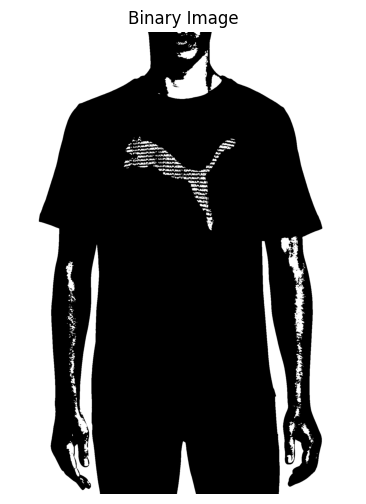

Custom contours detected: 472
OpenCV contours detected: 305

CONTOUR COMPARISON (Sorted by Area - Largest to Smallest)

Contour 0 (Area: ✓, BBox: ✓)
  Area  -> Custom:  573320.00, OpenCV:  573320.00, Diff: 0.00
  BBox  -> Custom: (862, 0, 638, 2000), OpenCV: (862, 0, 638, 2000)

Contour 1 (Area: ✓, BBox: ✓)
  Area  -> Custom:  544619.50, OpenCV:  544619.50, Diff: 0.00
  BBox  -> Custom: (0, 0, 608, 2000), OpenCV: (0, 0, 608, 2000)

Contour 2 (Area: ✓, BBox: ✓)
  Area  -> Custom:   19536.50, OpenCV:   19536.50, Diff: 0.00
  BBox  -> Custom: (669, 79, 188, 211), OpenCV: (669, 79, 188, 211)

Contour 3 (Area: ✓, BBox: ✓)
  Area  -> Custom:   13723.00, OpenCV:   13723.00, Diff: 0.00
  BBox  -> Custom: (1171, 885, 102, 442), OpenCV: (1171, 885, 102, 442)

Contour 4 (Area: ✓, BBox: ✓)
  Area  -> Custom:    9451.00, OpenCV:    9451.00, Diff: 0.00
  BBox  -> Custom: (722, 1772, 82, 228), OpenCV: (722, 1772, 82, 228)

Contour 5 (Area: ✓, BBox: ✓)
  Area  -> Custom:    2281.50, OpenCV:    2281.50

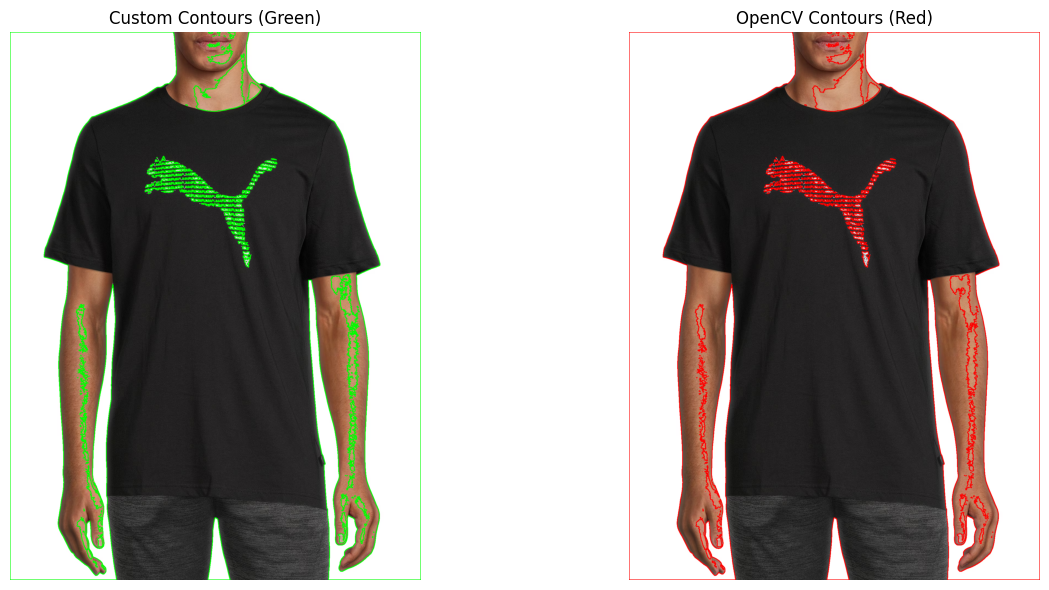

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

sys.path.append("../src")

import contour_detection
importlib.reload(contour_detection)

# =========================
# LOAD IMAGE
# =========================

image_path = r"E:\brand_detection\Brand-Detection\Cloth\a2.png"
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# =========================
# PREPROCESSING (CRITICAL)
# =========================

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Convert to binary image
_, binary = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# =========================
# SHOW BINARY IMAGE
# =========================
plt.figure(figsize=(6, 6))
plt.title("Binary Image")
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

# =========================
# CALL YOUR FUNCTIONS
# =========================

custom_contours, _ = contour_detection.get_contours(binary)

print(f"Custom contours detected: {len(custom_contours)}")

# =========================
# OPENCV FOR COMPARISON
# =========================

opencv_contours, _ = cv2.findContours(
    binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

print(f"OpenCV contours detected: {len(opencv_contours)}")

# =========================
# SORT CONTOURS BY AREA
# =========================

# Sort custom contours by area (descending)
custom_sorted = sorted(
    custom_contours, 
    key=lambda c: contour_detection.get_area(c), 
    reverse=True
)

# Sort OpenCV contours by area (descending)
opencv_sorted = sorted(
    opencv_contours, 
    key=lambda c: cv2.contourArea(c), 
    reverse=True
)

# =========================
# NUMERICAL COMPARISON
# =========================

print("\n" + "="*70)
print("CONTOUR COMPARISON (Sorted by Area - Largest to Smallest)")
print("="*70)

min_count = min(len(custom_sorted), len(opencv_sorted))

for i in range(min_count):
    custom_area = contour_detection.get_area(custom_sorted[i])
    custom_bbox = contour_detection.get_bounding_rects(custom_sorted[i])

    ocv_contour = opencv_sorted[i].reshape(-1, 2)
    ocv_area = cv2.contourArea(ocv_contour)
    ocv_bbox = cv2.boundingRect(ocv_contour)
    
    # Calculate differences
    area_diff = abs(custom_area - ocv_area)
    bbox_match = custom_bbox == ocv_bbox
    
    # Status indicators
    area_status = "✓" if area_diff < 1.0 else "✗"
    bbox_status = "✓" if bbox_match else "✗"

    print(f"\nContour {i} (Area: {area_status}, BBox: {bbox_status})")
    print(f"  Area  -> Custom: {custom_area:>10.2f}, OpenCV: {ocv_area:>10.2f}, Diff: {area_diff:.2f}")
    print(f"  BBox  -> Custom: {custom_bbox}, OpenCV: {ocv_bbox}")

# =========================
# SUMMARY STATISTICS
# =========================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

total_contours = min_count
area_matches = sum(
    1 for i in range(min_count) 
    if abs(contour_detection.get_area(custom_sorted[i]) - 
           cv2.contourArea(opencv_sorted[i])) < 1.0
)
bbox_matches = sum(
    1 for i in range(min_count)
    if contour_detection.get_bounding_rects(custom_sorted[i]) == 
       cv2.boundingRect(opencv_sorted[i])
)

print(f"Total contours compared: {total_contours}")
print(f"Area matches: {area_matches}/{total_contours} ({100*area_matches/total_contours:.1f}%)")
print(f"BBox matches: {bbox_matches}/{total_contours} ({100*bbox_matches/total_contours:.1f}%)")

# =========================
# VISUAL COMPARISON
# =========================

vis_custom = image.copy()
vis_opencv = image.copy()

# Draw custom contours (green)
for contour in custom_contours:
    pts = np.array(contour, dtype=np.int32)
    if len(pts) >= 2:
        cv2.polylines(vis_custom, [pts], True, (0, 255, 0), 2)

# Draw OpenCV contours (red)
cv2.drawContours(vis_opencv, opencv_contours, -1, (0, 0, 255), 2)

# Create side-by-side visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Custom Contours (Green)")
plt.imshow(cv2.cvtColor(vis_custom, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("OpenCV Contours (Red)")
plt.imshow(cv2.cvtColor(vis_opencv, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

# =========================
# OVERLAY COMPARISON
# =========================

# Create overlay to see differences
vis_overlay = image.copy()

# Draw OpenCV contours in red
cv2.drawContours(vis_overlay, opencv_contours, -1, (0, 0, 255), 2)

# Draw custom contours in green
for contour in custom_contours:
    pts = np.array(contour, dtype=np.int32)
    if len(pts) >= 2:
        cv2.polylines(vis_overlay, [pts], True, (0, 255, 0), 2)